# Capturing mean-reverting process using Sig Trader

### 0. Import librairies

In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

### 1. Define some utils

In [2]:
def generate_synthetic_mean_reverting(batch_size: int, T: int, delta_t: float, X_0: float, sigma_x: float, kappa: float) -> torch.Tensor:

    n_points = int(T / delta_t)
    mean_revert_paths = torch.zeros(batch_size, n_points)
    mean_revert_paths[:, 0] = 0

    for i in range(1, n_points):
        mean_revert_paths[:, i] = mean_revert_paths[:, i - 1] - kappa*mean_revert_paths[:, i - 1]*delta_t + sigma_x*torch.randn(batch_size)*np.sqrt(delta_t)

    return mean_revert_paths.reshape(batch_size, n_points, 1)

### 2. Generate synthetic data

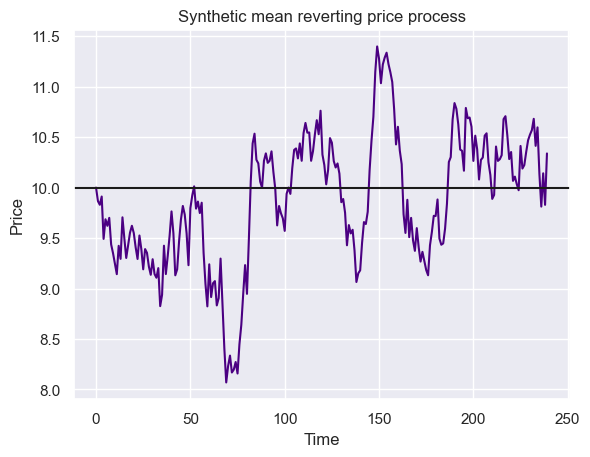

In [3]:
X_0 = 10
sigma_x = 10
kappa = 100
batch_size = 1000
T = 30 * (1/252) # time horizon (30 days)
freq = 252*8 # hourly data
delta_t = 1/freq
drift = 0
synthetic_mean_revert = generate_synthetic_mean_reverting(batch_size, T, delta_t, X_0, sigma_x, kappa)
price_paths = X_0 + synthetic_mean_revert + drift*torch.arange(0, T, delta_t).reshape(1, -1, 1)
n_points = price_paths.shape[1]
info_data = torch.zeros(batch_size, n_points, 0) # no info data

plt.plot(price_paths[0], color='indigo')
plt.axhline(y=X_0, color='k', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Synthetic mean reverting price process")
plt.show()

### 3. Fit Order 1 Sig Trader

In [4]:
# Sig Trader parameters
depth = 1
delta = 1 # variance criterion, not very important (simply rescale the positions xi)
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(price_paths, info_data)

# flip functionals
for i in range(ts.d):
    ts.functionals[i] = -ts.functionals[i]

ts.print_functionals()

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([0.2082])
Level 1:
tensor([-0.1988, -1.5659])


### 4. Trade on in-sample data

In [5]:
n_traded_mean_reverts = 10 # we trade 20 pairs (uncorrelated) from the batch
all_hourly_pnl = torch.zeros(n_traded_mean_reverts, n_points) # hourly pnl for each pair
min_steps = 5 # minimum number of steps before trading

for i in range(n_traded_mean_reverts):
    # trading on the i-th pair in the batch
    X = price_paths[i,:,:]
    f = info_data[i,:,:]
    xi = ts.trade(X, f, min_steps=min_steps)
    hourly_pnl_each_asset = ts.compute_pnl(X, xi) # daily pnl on this pair
    hourly_pnl_pair = torch.sum(hourly_pnl_each_asset, dim=1) # daily pnl of the pair (sum of pnl for each asset)
    all_hourly_pnl[i,1:] = hourly_pnl_pair

portfolio_hourly_pnl = torch.sum(all_hourly_pnl, dim=0) # daily pnl of the portfolio (sum of pnl for each pairs)
portfolio_cum_pnl = torch.cumsum(portfolio_hourly_pnl, dim=0) # cumulative pnl of the portfolio

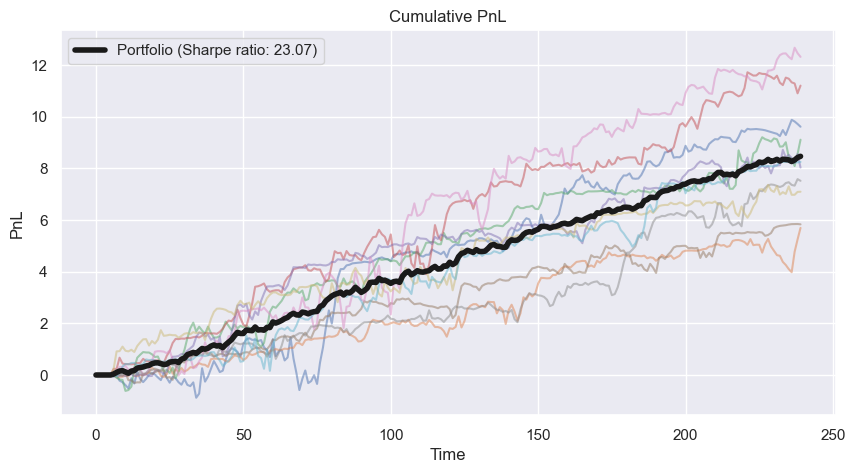

In [6]:
# plot the cumulative pnl of the portfolio
plt.figure(figsize=(10,5))
# plot the cumulative pnl of each pair we trade
for i in range(n_traded_mean_reverts):
    plt.plot(torch.cumsum(all_hourly_pnl[i,:], dim=0), alpha=0.5)

# plot the cumulative pnl of the portfolio
rescaled_portfolio_cum_pnl = portfolio_cum_pnl/n_traded_mean_reverts

portfolio_mean_return = torch.mean(portfolio_hourly_pnl)
portfolio_std_return = torch.std(portfolio_hourly_pnl)
portfolio_sharpe_ratio = portfolio_mean_return/portfolio_std_return * np.sqrt(freq)

plt.plot(rescaled_portfolio_cum_pnl, lw=4, color='k', label=f'Portfolio (Sharpe ratio: {portfolio_sharpe_ratio:.2f})')
plt.legend()

plt.title("Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.show()

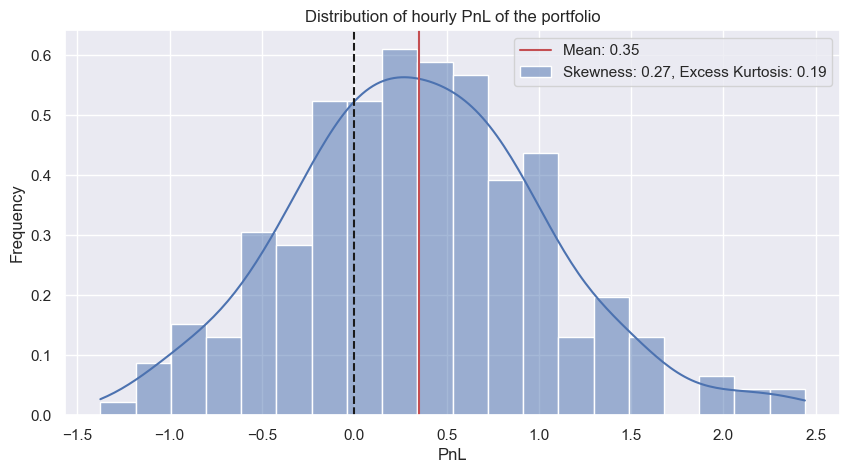

In [7]:
mean_hourly_pnl = torch.mean(portfolio_hourly_pnl)
std_hourly_pnl = torch.std(portfolio_hourly_pnl)
skew_hourly_pnl = torch.mean((portfolio_hourly_pnl - mean_hourly_pnl)**3)/std_hourly_pnl**3
kurt_hourly_pnl = torch.mean((portfolio_hourly_pnl - mean_hourly_pnl)**4)/std_hourly_pnl**4 - 3

# dist of hourly pnl of the portfolio
plt.figure(figsize=(10,5))
sns.histplot(portfolio_hourly_pnl, kde=True, bins=20, stat='density', label=f'Skewness: {skew_hourly_pnl:.2f}, Excess Kurtosis: {kurt_hourly_pnl:.2f}')
plt.axvline(x=0, color='k', ls='--')
plt.axvline(x=mean_hourly_pnl, color='r', label=f'Mean: {mean_hourly_pnl:.2f}')
plt.title("Distribution of hourly PnL of the portfolio")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 5. Trade on out-of-sample data

In [8]:
n_traded_mean_reverts = 10 # we trade 20 pairs (uncorrelated) from the batch
oos_all_hourly_pnl = torch.zeros(n_traded_mean_reverts, n_points) # hourly pnl for each pair

# new, out-of-sample data
oos_mean_reverts = generate_synthetic_mean_reverting(n_traded_mean_reverts, T, delta_t, X_0, sigma_x, kappa)
oos_price_paths = X_0 + oos_mean_reverts + drift*torch.arange(0, T, delta_t).reshape(1, -1, 1)
oos_info_data = torch.zeros((n_traded_mean_reverts, n_points, 0)) # no info data

for i in range(n_traded_mean_reverts):
    # trading on the i-th pair in the batch
    X = oos_price_paths[i,:,:]
    f = oos_info_data[i,:,:]
    xi = ts.trade(X, f)
    hourly_pnl_each_mean_revert = ts.compute_pnl(X, xi)[:,0] # daily pnl on this pair
    oos_all_hourly_pnl[i,1:] = hourly_pnl_each_mean_revert

oos_portfolio_hourly_pnl = torch.sum(oos_all_hourly_pnl, dim=0) # daily pnl of the portfolio (sum of pnl for each pairs)
oos_portfolio_cum_pnl = torch.cumsum(oos_portfolio_hourly_pnl, dim=0) # cumulative pnl of the portfolio

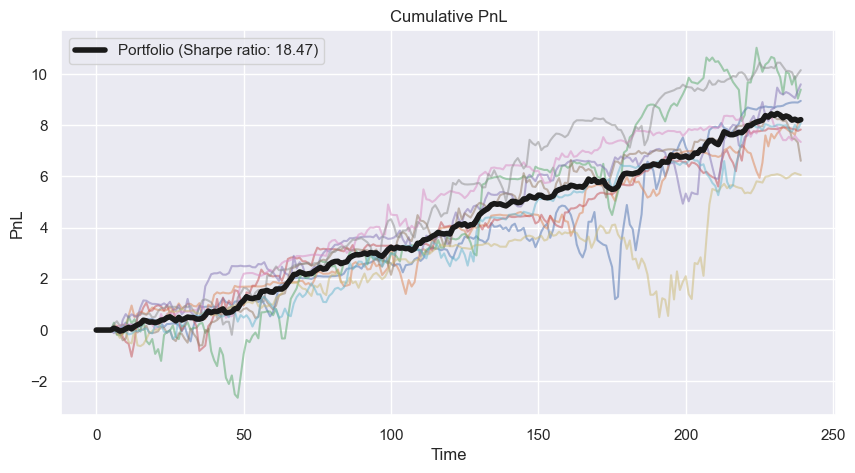

In [9]:
# plot the cumulative pnl of the portfolio
plt.figure(figsize=(10,5))
# plot the cumulative pnl of each pair we trade
for i in range(n_traded_mean_reverts):
    plt.plot(torch.cumsum(oos_all_hourly_pnl[i,:], dim=0), alpha=0.5)

# plot the cumulative pnl of the portfolio
rescaled_oos_portfolio_cum_pnl = oos_portfolio_cum_pnl/n_traded_mean_reverts

oos_portfolio_mean_return = torch.mean(oos_portfolio_hourly_pnl)
oos_portfolio_std_return = torch.std(oos_portfolio_hourly_pnl)
oos_portfolio_sharpe_ratio = oos_portfolio_mean_return/oos_portfolio_std_return * np.sqrt(freq)

plt.plot(rescaled_oos_portfolio_cum_pnl, lw=4, color='k', label=f'Portfolio (Sharpe ratio: {oos_portfolio_sharpe_ratio:.2f})')
plt.legend()

plt.title("Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.show()

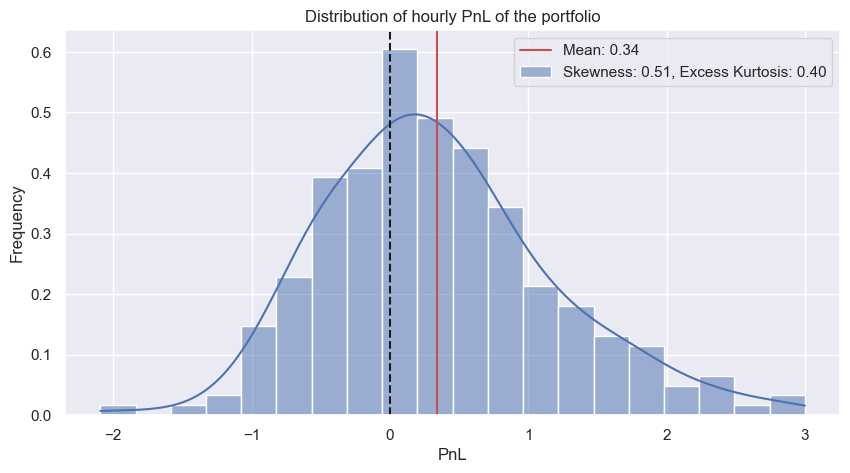

In [10]:
oos_mean_hourly_pnl = torch.mean(oos_portfolio_hourly_pnl)
oos_std_hourly_pnl = torch.std(oos_portfolio_hourly_pnl)
oos_skew_hourly_pnl = torch.mean((oos_portfolio_hourly_pnl - oos_mean_hourly_pnl)**3)/oos_std_hourly_pnl**3
oos_kurt_hourly_pnl = torch.mean((oos_portfolio_hourly_pnl - oos_mean_hourly_pnl)**4)/oos_std_hourly_pnl**4 - 3

# dist of hourly pnl of the portfolio
plt.figure(figsize=(10,5))
sns.histplot(oos_portfolio_hourly_pnl, kde=True, bins=20, stat='density', label=f'Skewness: {oos_skew_hourly_pnl:.2f}, Excess Kurtosis: {oos_kurt_hourly_pnl:.2f}')
plt.axvline(x=0, color='k', ls='--')
plt.axvline(x=oos_mean_hourly_pnl, color='r', label=f'Mean: {oos_mean_hourly_pnl:.2f}')
plt.title("Distribution of hourly PnL of the portfolio")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()

We see that performance is the same between in-sample and out-of-sample data. This means that the Sig Trader is able to generalize and does not overfit. In other words, the Sig Trader truly understands how to capture pairs trading signals.